In [13]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

## Defining a discriminator
High level explanation of a discriminator is simple classifier whose job is to differentiate between real and fake MNIST digits. Fake images being from our generator

* Instead of using Max/AvgPooling layers increased stride acts as a downsampler

In [17]:
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout
from tensorflow.keras.models import Model

def discriminator_model(input_shape = (28, 28, 1)) -> Model:
    
    network_input = Input(shape=input_shape)
    
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    
    model = Model(network_input, layer)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator_model()
discriminator.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 64)          0   

## Generating a REAL + FAKE dataset
MNIST dataset gave us real images, but our model requires fake models to differentiate from real ones

In [43]:
def generate_real_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    random_sample_indexes = np.random.randint(0, x_train.shape[0], n_samples)
    random_samples = x_train[random_sample_indexes]
    
    return (random_samples, np.ones((n_samples, 1)))


def generate_fake_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    
    return (X, np.zeros((n_samples, 1)))

In [58]:
import matplotlib.pyplot as plt

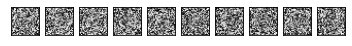

In [62]:
fake_images, _ = generate_fake_samples(10)

for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [70]:
def dataset(n_real: int, n_fake: int) -> (np.ndarray, np.ndarray):
    
    real_X, real_labels = generate_real_samples(n_real)
    fake_X, fake_labels = generate_fake_samples(n_fake)
    
    X = np.concatenate((real_X, fake_X), axis=0)
    y = np.concatenate((real_labels, fake_labels))
    
    return X, y

In [75]:
discriminator = discriminator_model()
X, y = dataset(1000, 800)
X_val, y_val = dataset(500, 500)
history = discriminator.fit(X, y, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
57/57 [==============================] - 1s 18ms/step - loss: 0.1353 - accuracy: 0.9589 - val_loss: 1.1315e-04 - val_accuracy: 1.0000
Epoch 2/10
57/57 [==============================] - 1s 21ms/step - loss: 1.8483e-04 - accuracy: 1.0000 - val_loss: 6.2111e-05 - val_accuracy: 1.0000
Epoch 3/10
57/57 [==============================] - 1s 21ms/step - loss: 1.4540e-04 - accuracy: 1.0000 - val_loss: 4.4581e-05 - val_accuracy: 1.0000
Epoch 4/10
57/57 [==============================] - 1s 21ms/step - loss: 8.2047e-05 - accuracy: 1.0000 - val_loss: 3.4262e-05 - val_accuracy: 1.0000
Epoch 5/10
57/57 [==============================] - 1s 23ms/step - loss: 5.4320e-05 - accuracy: 1.0000 - val_loss: 2.7483e-05 - val_accuracy: 1.0000
Epoch 6/10
57/57 [==============================] - 1s 21ms/step - loss: 4.2139e-05 - accuracy: 1.0000 - val_loss: 2.2853e-05 - val_accuracy: 1.0000
Epoch 7/10
57/57 [==============================] - 1s 21ms/step - loss: 4.5899e-05 - accuracy: 1.0000 - val_l

In [84]:
X_test, _ = dataset(5, 5)
print('Testing')
np.round(discriminator.predict(X_test))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)